In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

import pywt

In [6]:
X_train = pd.read_csv("../input/career-con-2019/X_train.csv")
y_train = pd.read_csv("../input/career-con-2019/y_train.csv")

In [7]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [8]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [9]:
X_train_wo = X_train.drop(['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W'], axis = 1)

In [10]:
X_train_wo.head()

,row_id,series_id,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [11]:
# from sklearn.model_selection import GroupKFold

# def group_kfold(train_df,y,folds):
#     """Generator that yields train and test indexes."""
#     folds = GroupKFold(n_splits=folds)
#     f_t = []
#     f_test = []
#     for train_idx, test_idx in folds.split(train_df, groups=y['group_id'].values):
#         f_t.append(train_idx)
#         f_test.append(test_idx)
        
#     return f_t,f_test

### Scalograms

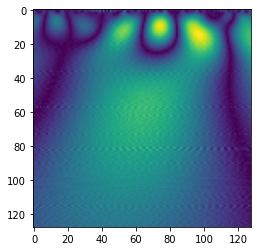

In [12]:
scales = np.arange(1,129)
coef , freq = pywt.cwt(np.array(X_train.angular_velocity_Y.values)[0:128], scales, wavelet='gaus1')
plt.imshow(abs(coef))

In [13]:
coef.shape

(128, 128)

In [1]:
scales = np.arange(1,129)
coef , freq = pywt.cwt(np.array(X_train.angular_velocity_Z.values)[0:128], scales, wavelet='gaus1')
plt.imshow(abs(coef))

NameError: name 'np' is not defined

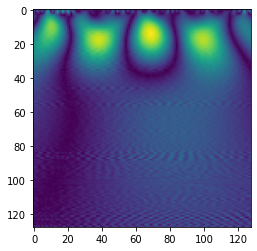

In [15]:
scales = np.arange(1,129)
coef , freq = pywt.cwt(np.array(X_train.angular_velocity_X.values)[0:128], scales, wavelet='gaus1')
plt.imshow(abs(coef))

In [16]:
from tqdm.auto import tqdm

In [17]:
scales = np.arange(1,129)
dataset = np.zeros((X_train_wo.shape[0]//128,6,128,128))
for i in tqdm(range(0,  X_train_wo.shape[0],128)):
    
    coef_x , freq = pywt.cwt(np.array(X_train.angular_velocity_X.values)[i:i+128], scales, wavelet='gaus1')
    coef_y , freq = pywt.cwt(np.array(X_train.angular_velocity_Y.values)[i:i+128], scales, wavelet='gaus1')
    coef_z , freq = pywt.cwt(np.array(X_train.angular_velocity_Z.values)[i:i+128], scales, wavelet='gaus1')
    coef_lx , freq = pywt.cwt(np.array(X_train.linear_acceleration_X.values)[i:i+128], scales, wavelet='gaus1')
    coef_ly , freq = pywt.cwt(np.array(X_train.linear_acceleration_Y.values)[i:i+128], scales, wavelet='gaus1')
    coef_lz , freq = pywt.cwt(np.array(X_train.linear_acceleration_Z.values)[i:i+128], scales, wavelet='gaus1')
    
    
    img = np.concatenate((abs(coef_x).reshape((128,128,1)),
                    abs(coef_y).reshape((128,128,1)), 
                    abs(coef_z).reshape((128,128,1)),
                    abs(coef_lx).reshape((128,128,1)),
                    abs(coef_ly).reshape((128,128,1)),
                    abs(coef_lz).reshape((128,128,1))),                   
                    axis = 2 )
    
    img = img.reshape(6,128,128)
    
    dataset[int(i//128)] = img
    
    

  0%|          | 0/3810 [00:00<?, ?it/s]

In [18]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [19]:
dataset_tensor = torch.from_numpy(dataset)

In [20]:
dataset_tensor.shape

torch.Size([3810, 6, 128, 128])

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target = le.fit_transform(y_train['surface'])
# target = torch.nn.functional.one_hot(torch.from_numpy(target))


In [22]:
target =torch.from_numpy(target)

In [23]:
le.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [89]:
class WaveletDataset(Dataset):
    def __init__(self, data, y):
        self.images = data
        self.labels = y
        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        return image, self.labels[idx]
    
    
        
        
        

In [90]:
wavelet_data = WaveletDataset(dataset_tensor, target)

In [91]:
for x, y in wavelet_data:
    print(x.shape)
    print(y)
    break

torch.Size([6, 128, 128])
tensor(2)


In [92]:
from torch.utils.data import random_split
group_train_index, group_val_index = random_split(np.unique(y_train['group_id']), [73-20, 20])
group_train_index, group_val_index = group_train_index.indices, group_val_index.indices


In [93]:
train_index = []
for i in range(0, len(group_train_index)):
    train_index.append(list(y_train[y_train['group_id'] == group_train_index[i]]['series_id'].values))
train_index = [item for sublist in train_index for item in sublist]

val_index = []
for i in range(0, len(group_val_index)):
    val_index.append(list(y_train[y_train['group_id'] == group_val_index[i]]['series_id'].values))
val_index = [item for sublist in val_index for item in sublist]

In [94]:
from torch.utils.data import Subset
train_ds=Subset(wavelet_data,train_index)
val_ds=Subset(wavelet_data,val_index)

In [95]:
# from torch.utils.data import random_split

# len_histo = len(wavelet_data)
# len_train = int(0.8 * len_histo)
# len_val = len_histo - len_train

In [96]:
# train_ds, val_ds = random_split(wavelet_data, [len_train, len_val])

In [103]:
print(f"Train Dataset Length: {len(train_ds)}")
print(f"Validation Dataset Length: {len(val_ds)}")

Train Dataset Length: 2702
Validation Dataset Length: 1108


In [104]:
#Data Loader

from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size = 256, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = 256, shuffle = False)

In [105]:
for x,y in train_dl:
    print(x.shape)
    print(y)
    break


torch.Size([256, 6, 128, 128])
tensor([8, 1, 2, 2, 6, 1, 8, 2, 4, 2, 8, 5, 1, 1, 6, 5, 1, 5, 1, 2, 3, 1, 7, 1,
        5, 5, 7, 1, 1, 2, 5, 8, 4, 6, 1, 8, 5, 2, 1, 1, 6, 1, 0, 8, 2, 1, 7, 8,
        7, 8, 2, 7, 7, 8, 2, 8, 5, 2, 8, 8, 1, 0, 4, 5, 2, 4, 4, 7, 8, 7, 6, 5,
        8, 5, 8, 1, 1, 0, 2, 2, 1, 7, 1, 2, 1, 0, 8, 5, 5, 7, 1, 2, 5, 4, 5, 1,
        5, 4, 5, 5, 5, 5, 5, 4, 8, 2, 0, 2, 8, 7, 8, 0, 1, 0, 5, 1, 6, 5, 7, 7,
        8, 5, 7, 5, 7, 6, 5, 8, 5, 2, 4, 1, 5, 5, 6, 5, 0, 2, 1, 7, 8, 4, 4, 8,
        8, 2, 6, 0, 1, 5, 8, 1, 5, 5, 0, 0, 2, 8, 1, 2, 7, 0, 7, 8, 7, 1, 8, 6,
        4, 8, 8, 6, 0, 8, 1, 6, 8, 8, 6, 0, 8, 5, 1, 1, 6, 1, 1, 7, 2, 1, 8, 0,
        2, 8, 8, 4, 7, 4, 7, 6, 8, 2, 1, 0, 2, 8, 7, 8, 5, 8, 8, 4, 1, 0, 1, 1,
        8, 1, 5, 0, 7, 6, 2, 8, 2, 8, 5, 5, 1, 8, 2, 1, 8, 1, 2, 2, 2, 5, 8, 6,
        2, 8, 1, 8, 8, 5, 8, 7, 6, 8, 6, 7, 7, 4, 8, 4])


In [106]:
import torch.nn as nn
import torch.nn.functional as F

In [107]:
# Implementing a helper function to calculate the output size of a CNN layer.

def findConv2OutShape(H_in, W_in, conv, pool = 2):
    #get conv parameter
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    
    H_out=np.floor((H_in+2*padding[0]- dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]- dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        H_out/=pool
        W_out/=pool
        
    return int(H_out),int(W_out)
    

In [108]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        C_in, H_in, W_in = params["input_shape"]
        init_f = params['initial_filters']
        num_fc1 = params["num_fc1"]
        num_fc2 = params["num_fc2"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size = 3)
        h,w = findConv2OutShape(H_in, W_in, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w = findConv2OutShape(h, w, self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w = findConv2OutShape(h, w, self.conv3)
        
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w = findConv2OutShape(h, w, self.conv4)
        
        self.num_flatten = h*w*8*init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_fc2)
        self.fc3 = nn.Linear(num_fc2,num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate, training = self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, self.dropout_rate, training = self.training)
        x = self.fc3(x)
        
        return F.log_softmax(x, dim = 1)


In [109]:
params = {"input_shape": (6,128,128), 
         "initial_filters" : 8,
         "num_fc1": 1028,
          "num_fc2":100,
         "dropout_rate": 0.30,
         "num_classes": 10
         }

In [110]:
cnn_model = Net(params)

In [111]:
print(cnn_model)

Net(
  (conv1): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [113]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model = cnn_model.to(device)
    cnn_model = cnn_model.float()
else:
    device = 'cpu'
    cnn_model = cnn_model.float()

In [114]:
# loss_func = nn.NLLLoss(reduction = 'sum')

from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr = 3e-4)

In [115]:
def get_lr(opt):
    for A in opt.param_groups:
        return A['lr']
current_lr = get_lr(opt)

In [116]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5,
patience=20,verbose=1)

In [117]:
def metrics_batch(output, target):
    #get output class
    pred = output.argmax(dim = 1, keepdim = True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    
    return corrects


def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [118]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check = False, opt = None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in tqdm(dataset_dl):
        xb = xb.to(device).float()
        yb = yb.to(device)
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func,output, yb, opt)
        running_loss+=loss_b 
        running_metric+= metric_b
        
        if sanity_check is True:
            break
            
    loss = running_loss/float(len_data)
    metric = running_metric/float(len_data)
    
    return loss, metric
            
    

In [119]:
def train_val(model, param):
    num_epochs = param['num_epochs']
    loss_func = param["loss_func"]
    opt = param["optimizer"]
    train_dl = param["train_dl"]
    val_dl = param["val_dl"]
    sanity_check = param["sanity_check"]
    lr_scheduler = param["lr_scheduler"]
    path2weights = param['path2weights']
    loss_history = {
        "train": [],
        "val": []
    }
    
    metric_history = {
        "train": [],
        "val": []
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print(f'Epochs{epoch+1}/{num_epochs}, current lr: {current_lr}')
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)
        
        model.eval()
        val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check, opt =None)
        
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Saved new Weights")
            
        lr_scheduler.step()
        
        print("train loss: %.6f, train accuracy: %.6f, dev loss: %.6f, accuracy: %.2f"%(train_loss,train_metric*100, val_loss,100*val_metric))
        print("-"*10)
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history
        
    

In [120]:
from torch.optim.lr_scheduler import CosineAnnealingLR


In [121]:
import copy
import os

loss_func = nn.CrossEntropyLoss(reduction='sum')
# opt = optim.Adam(model_resnet.parameters(), lr = 1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)


os.makedirs("./models", exist_ok=True)
params_train={
"num_epochs": 500,
"optimizer": opt,
"loss_func": loss_func,
"train_dl": train_dl,
"val_dl": val_dl,
"sanity_check": False,
"lr_scheduler": lr_scheduler,
"path2weights": "./models/resnet18.pt",
}

In [122]:
model_trained, loss_hist, metric_hist = train_val(cnn_model, params_train)

Epochs1/500, current lr: 0.0003


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 2.124592, train accuracy: 18.837898, dev loss: 2.125256, accuracy: 6.59
----------
Epochs2/500, current lr: 0.0002714480406590546


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 2.072508, train accuracy: 20.244264, dev loss: 2.072369, accuracy: 10.29
----------
Epochs3/500, current lr: 0.00019669804065905458


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 2.055984, train accuracy: 21.761658, dev loss: 2.045921, accuracy: 22.65
----------
Epochs4/500, current lr: 0.00010430195934094532


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 2.046791, train accuracy: 22.057735, dev loss: 2.042707, accuracy: 10.20
----------
Epochs5/500, current lr: 2.955195934094536e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 2.029222, train accuracy: 23.797187, dev loss: 2.042308, accuracy: 12.00
----------
Epochs6/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 2.026364, train accuracy: 23.686158, dev loss: 2.042097, accuracy: 11.82
----------
Epochs7/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.032899, train accuracy: 23.612139, dev loss: 2.043656, accuracy: 10.83
----------
Epochs8/500, current lr: 0.00010430195934094538


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 2.025734, train accuracy: 23.538120, dev loss: 2.033299, accuracy: 14.08
----------
Epochs9/500, current lr: 0.0001966980406590547


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 2.010933, train accuracy: 24.907476, dev loss: 1.992292, accuracy: 16.06
----------
Epochs10/500, current lr: 0.00027144804065905477


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.004422, train accuracy: 25.166543, dev loss: 2.001091, accuracy: 10.74
----------
Epochs11/500, current lr: 0.00030000000000000014


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.938020, train accuracy: 29.903775, dev loss: 1.942934, accuracy: 14.17
----------
Epochs12/500, current lr: 0.0002714480406590549


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.916674, train accuracy: 29.274611, dev loss: 1.962593, accuracy: 16.97
----------
Epochs13/500, current lr: 0.00019669804065905474


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.886122, train accuracy: 31.051073, dev loss: 1.936398, accuracy: 15.43
----------
Epochs14/500, current lr: 0.00010430195934094543


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.876989, train accuracy: 31.458179, dev loss: 1.927255, accuracy: 18.41
----------
Epochs15/500, current lr: 2.9551959340945397e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.870093, train accuracy: 31.865285, dev loss: 1.913513, accuracy: 15.43
----------
Epochs16/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.871030, train accuracy: 31.643227, dev loss: 1.912312, accuracy: 15.61
----------
Epochs17/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.869668, train accuracy: 32.235381, dev loss: 1.922938, accuracy: 14.62
----------
Epochs18/500, current lr: 0.00010430195934094539


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.874982, train accuracy: 31.717246, dev loss: 1.933538, accuracy: 14.53
----------
Epochs19/500, current lr: 0.00019669804065905477


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.856697, train accuracy: 32.198372, dev loss: 1.930767, accuracy: 18.14
----------
Epochs20/500, current lr: 0.0002714480406590549


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.862747, train accuracy: 31.791266, dev loss: 1.892581, accuracy: 20.04
----------
Epochs21/500, current lr: 0.00030000000000000035


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.855051, train accuracy: 32.309400, dev loss: 1.943320, accuracy: 15.25
----------
Epochs22/500, current lr: 0.000271448040659055


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.817305, train accuracy: 34.678016, dev loss: 1.896670, accuracy: 17.69
----------
Epochs23/500, current lr: 0.0001966980406590552


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.810447, train accuracy: 34.678016, dev loss: 1.846892, accuracy: 29.15
----------
Epochs24/500, current lr: 0.00010430195934094555


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.789101, train accuracy: 34.492968, dev loss: 1.844719, accuracy: 29.24
----------
Epochs25/500, current lr: 2.955195934094544e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.780760, train accuracy: 35.048113, dev loss: 1.854545, accuracy: 27.53
----------
Epochs26/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.779252, train accuracy: 35.714286, dev loss: 1.854778, accuracy: 27.71
----------
Epochs27/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.785822, train accuracy: 34.418949, dev loss: 1.857604, accuracy: 26.35
----------
Epochs28/500, current lr: 0.00010430195934094542


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.784269, train accuracy: 35.159141, dev loss: 1.816115, accuracy: 32.40
----------
Epochs29/500, current lr: 0.00019669804065905485


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.798330, train accuracy: 34.937084, dev loss: 1.827115, accuracy: 31.32
----------
Epochs30/500, current lr: 0.00027144804065905504


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.800234, train accuracy: 33.345670, dev loss: 1.881509, accuracy: 23.47
----------
Epochs31/500, current lr: 0.0003000000000000005


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.765203, train accuracy: 34.270910, dev loss: 1.771466, accuracy: 36.37
----------
Epochs32/500, current lr: 0.0002714480406590552


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.773999, train accuracy: 34.307920, dev loss: 1.849228, accuracy: 30.69
----------
Epochs33/500, current lr: 0.00019669804065905507


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.790080, train accuracy: 34.344930, dev loss: 1.821025, accuracy: 28.16
----------
Epochs34/500, current lr: 0.00010430195934094565


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.754696, train accuracy: 35.196151, dev loss: 1.740651, accuracy: 36.46
----------
Epochs35/500, current lr: 2.955195934094549e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.738097, train accuracy: 36.417469, dev loss: 1.806702, accuracy: 28.16
----------
Epochs36/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.727459, train accuracy: 36.972613, dev loss: 1.804262, accuracy: 28.70
----------
Epochs37/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.731260, train accuracy: 36.417469, dev loss: 1.754528, accuracy: 33.66
----------
Epochs38/500, current lr: 0.00010430195934094545


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.723000, train accuracy: 37.786825, dev loss: 1.763513, accuracy: 32.22
----------
Epochs39/500, current lr: 0.00019669804065905493


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.728400, train accuracy: 35.603257, dev loss: 1.771536, accuracy: 34.84
----------
Epochs40/500, current lr: 0.0002714480406590552


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.748474, train accuracy: 35.973353, dev loss: 1.790679, accuracy: 33.84
----------
Epochs41/500, current lr: 0.00030000000000000073


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.724290, train accuracy: 36.195411, dev loss: 1.790336, accuracy: 31.14
----------
Epochs42/500, current lr: 0.0002714480406590557


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.713000, train accuracy: 37.009623, dev loss: 1.798399, accuracy: 27.17
----------
Epochs43/500, current lr: 0.00019669804065905523


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.685203, train accuracy: 38.490007, dev loss: 1.767852, accuracy: 30.23
----------
Epochs44/500, current lr: 0.00010430195934094576


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.690205, train accuracy: 37.231680, dev loss: 1.726730, accuracy: 38.00
----------
Epochs45/500, current lr: 2.9551959340945837e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.691842, train accuracy: 37.305699, dev loss: 1.758255, accuracy: 31.32
----------
Epochs46/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.682318, train accuracy: 37.120651, dev loss: 1.754893, accuracy: 31.23
----------
Epochs47/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.689584, train accuracy: 38.712065, dev loss: 1.732658, accuracy: 36.64
----------
Epochs48/500, current lr: 0.00010430195934094605


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.692855, train accuracy: 37.638786, dev loss: 1.701953, accuracy: 41.34
----------
Epochs49/500, current lr: 0.00019669804065905515


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.688140, train accuracy: 37.379719, dev loss: 1.724934, accuracy: 35.11
----------
Epochs50/500, current lr: 0.0002714480406590552


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.691133, train accuracy: 36.750555, dev loss: 1.814820, accuracy: 24.55
----------
Epochs51/500, current lr: 0.00030000000000000106


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.707945, train accuracy: 35.677276, dev loss: 1.703062, accuracy: 34.57
----------
Epochs52/500, current lr: 0.000271448040659056


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.690179, train accuracy: 37.860844, dev loss: 1.770478, accuracy: 27.89
----------
Epochs53/500, current lr: 0.00019669804065905547


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.679943, train accuracy: 38.267950, dev loss: 1.751588, accuracy: 30.23
----------
Epochs54/500, current lr: 0.00010430195934094539


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.658589, train accuracy: 40.007402, dev loss: 1.755933, accuracy: 27.53
----------
Epochs55/500, current lr: 2.955195934094557e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.652352, train accuracy: 38.452998, dev loss: 1.678043, accuracy: 39.98
----------
Epochs56/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.645912, train accuracy: 39.822354, dev loss: 1.679786, accuracy: 39.44
----------
Epochs57/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.655819, train accuracy: 38.490007, dev loss: 1.706763, accuracy: 36.28
----------
Epochs58/500, current lr: 0.00010430195934094507


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.652079, train accuracy: 38.601036, dev loss: 1.723775, accuracy: 31.05
----------
Epochs59/500, current lr: 0.00019669804065905523


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.658001, train accuracy: 38.415988, dev loss: 1.773088, accuracy: 29.60
----------
Epochs60/500, current lr: 0.0002714480406590553


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.660091, train accuracy: 38.564027, dev loss: 1.723141, accuracy: 39.89
----------
Epochs61/500, current lr: 0.0003000000000000013


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.658667, train accuracy: 38.267950, dev loss: 1.825807, accuracy: 27.53
----------
Epochs62/500, current lr: 0.0002714480406590556


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.663666, train accuracy: 39.230200, dev loss: 1.664112, accuracy: 40.52
----------
Epochs63/500, current lr: 0.00019669804065905566


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.640573, train accuracy: 40.007402, dev loss: 1.734062, accuracy: 38.99
----------
Epochs64/500, current lr: 0.00010430195934094551


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.626735, train accuracy: 39.600296, dev loss: 1.650710, accuracy: 38.27
----------
Epochs65/500, current lr: 2.955195934094563e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.611067, train accuracy: 40.525537, dev loss: 1.670026, accuracy: 37.82
----------
Epochs66/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.609683, train accuracy: 39.896373, dev loss: 1.669663, accuracy: 37.73
----------
Epochs67/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.617371, train accuracy: 40.229460, dev loss: 1.670153, accuracy: 37.64
----------
Epochs68/500, current lr: 0.00010430195934094509


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.608269, train accuracy: 40.229460, dev loss: 1.705859, accuracy: 33.57
----------
Epochs69/500, current lr: 0.00019669804065905528


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.605105, train accuracy: 41.228719, dev loss: 1.657516, accuracy: 39.17
----------
Epochs70/500, current lr: 0.000271448040659056


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.602622, train accuracy: 41.820873, dev loss: 1.714184, accuracy: 32.67
----------
Epochs71/500, current lr: 0.00030000000000000133


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.634007, train accuracy: 39.008142, dev loss: 1.706340, accuracy: 43.86
----------
Epochs72/500, current lr: 0.0002714480406590557


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.635938, train accuracy: 40.155440, dev loss: 1.690053, accuracy: 40.61
----------
Epochs73/500, current lr: 0.00019669804065905577


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.606660, train accuracy: 41.302739, dev loss: 1.606555, accuracy: 38.81
----------
Epochs74/500, current lr: 0.00010430195934094657


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.599555, train accuracy: 40.562546, dev loss: 1.649127, accuracy: 40.61
----------
Epochs75/500, current lr: 2.9551959340945648e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.576979, train accuracy: 41.635825, dev loss: 1.633510, accuracy: 38.45
----------
Epochs76/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.569352, train accuracy: 42.672095, dev loss: 1.632589, accuracy: 38.45
----------
Epochs77/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.579310, train accuracy: 42.487047, dev loss: 1.616766, accuracy: 41.06
----------
Epochs78/500, current lr: 0.00010430195934094616


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.568784, train accuracy: 41.820873, dev loss: 1.625218, accuracy: 41.06
----------
Epochs79/500, current lr: 0.00019669804065905547


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.582772, train accuracy: 42.598075, dev loss: 1.703289, accuracy: 37.00
----------
Epochs80/500, current lr: 0.00027144804065905634


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.595825, train accuracy: 39.711325, dev loss: 1.616623, accuracy: 38.36
----------
Epochs81/500, current lr: 0.00030000000000000176


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.575854, train accuracy: 42.672095, dev loss: 1.674108, accuracy: 34.03
----------
Epochs82/500, current lr: 0.0002714480406590567


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.583021, train accuracy: 42.672095, dev loss: 1.633318, accuracy: 41.43
----------
Epochs83/500, current lr: 0.00019669804065905707


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.570706, train accuracy: 41.931902, dev loss: 1.646881, accuracy: 41.70
----------
Epochs84/500, current lr: 0.00010430195934094573


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.561100, train accuracy: 41.820873, dev loss: 1.591354, accuracy: 43.95
----------
Epochs85/500, current lr: 2.9551959340945702e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.546311, train accuracy: 43.412287, dev loss: 1.568143, accuracy: 42.78
----------
Epochs86/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.532534, train accuracy: 42.487047, dev loss: 1.568198, accuracy: 42.69
----------
Epochs87/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.537528, train accuracy: 44.004441, dev loss: 1.577617, accuracy: 41.88
----------
Epochs88/500, current lr: 0.0001043019593409452


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.544159, train accuracy: 42.598075, dev loss: 1.584359, accuracy: 40.52
----------
Epochs89/500, current lr: 0.00019669804065905453


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.532091, train accuracy: 42.894152, dev loss: 1.606360, accuracy: 42.42
----------
Epochs90/500, current lr: 0.00027144804065905645


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.578836, train accuracy: 41.561806, dev loss: 1.707212, accuracy: 33.03
----------
Epochs91/500, current lr: 0.00030000000000000187


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.588632, train accuracy: 42.450037, dev loss: 1.610960, accuracy: 35.29
----------
Epochs92/500, current lr: 0.00027144804065905683


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.572173, train accuracy: 41.413768, dev loss: 1.648843, accuracy: 31.05
----------
Epochs93/500, current lr: 0.00019669804065905615


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.550473, train accuracy: 43.227239, dev loss: 1.525099, accuracy: 43.05
----------
Epochs94/500, current lr: 0.00010430195934094681


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.520958, train accuracy: 43.523316, dev loss: 1.581373, accuracy: 42.69
----------
Epochs95/500, current lr: 2.955195934094512e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.507088, train accuracy: 43.819393, dev loss: 1.555474, accuracy: 43.68
----------
Epochs96/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.504623, train accuracy: 44.596595, dev loss: 1.555381, accuracy: 43.77
----------
Epochs97/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.509576, train accuracy: 44.966691, dev loss: 1.529628, accuracy: 44.58
----------
Epochs98/500, current lr: 0.00010430195934094523


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.500939, train accuracy: 43.893412, dev loss: 1.512525, accuracy: 46.57
----------
Epochs99/500, current lr: 0.0001966980406590546


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.514767, train accuracy: 44.152480, dev loss: 1.526231, accuracy: 45.04
----------
Epochs100/500, current lr: 0.0002714480406590566


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.528088, train accuracy: 43.560326, dev loss: 1.663253, accuracy: 37.55
----------
Epochs101/500, current lr: 0.00030000000000000203


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.514734, train accuracy: 44.818653, dev loss: 1.539593, accuracy: 46.03
----------
Epochs102/500, current lr: 0.0002714480406590564


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.497079, train accuracy: 45.077720, dev loss: 1.537338, accuracy: 43.32
----------
Epochs103/500, current lr: 0.00019669804065905732


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.499537, train accuracy: 44.300518, dev loss: 1.587427, accuracy: 43.59
----------
Epochs104/500, current lr: 0.00010430195934094691


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.483072, train accuracy: 44.004441, dev loss: 1.517712, accuracy: 44.31
----------
Epochs105/500, current lr: 2.9551959340945783e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.471792, train accuracy: 46.002961, dev loss: 1.494267, accuracy: 47.56
----------
Epochs106/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.462011, train accuracy: 47.002221, dev loss: 1.496872, accuracy: 47.38
----------
Epochs107/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.468304, train accuracy: 45.780903, dev loss: 1.511061, accuracy: 45.40
----------
Epochs108/500, current lr: 0.00010430195934094303


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.466364, train accuracy: 45.521836, dev loss: 1.509672, accuracy: 46.21
----------
Epochs109/500, current lr: 0.0001966980406590515


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.463351, train accuracy: 44.707624, dev loss: 1.516500, accuracy: 45.13
----------
Epochs110/500, current lr: 0.0002714480406590497


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.472513, train accuracy: 44.485566, dev loss: 1.554218, accuracy: 47.74
----------
Epochs111/500, current lr: 0.0002999999999999958


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.477452, train accuracy: 45.003701, dev loss: 1.609488, accuracy: 41.25
----------
Epochs112/500, current lr: 0.00027144804065905136


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.482212, train accuracy: 44.966691, dev loss: 1.486411, accuracy: 47.29
----------
Epochs113/500, current lr: 0.00019669804065905228


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.455667, train accuracy: 45.114730, dev loss: 1.585726, accuracy: 47.65
----------
Epochs114/500, current lr: 0.00010430195934094379


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.459035, train accuracy: 45.817913, dev loss: 1.473375, accuracy: 48.47
----------
Epochs115/500, current lr: 2.955195934094583e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.433438, train accuracy: 46.706144, dev loss: 1.505654, accuracy: 44.22
----------
Epochs116/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.422586, train accuracy: 47.224278, dev loss: 1.503054, accuracy: 44.31
----------
Epochs117/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.428987, train accuracy: 46.965211, dev loss: 1.501159, accuracy: 47.47
----------
Epochs118/500, current lr: 0.00010430195934094634


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.439581, train accuracy: 46.706144, dev loss: 1.448617, accuracy: 47.65
----------
Epochs119/500, current lr: 0.0001966980406590549


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.450834, train accuracy: 45.817913, dev loss: 1.515910, accuracy: 45.49
----------
Epochs120/500, current lr: 0.00027144804065905645


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.458182, train accuracy: 45.706884, dev loss: 1.542625, accuracy: 39.98
----------
Epochs121/500, current lr: 0.00030000000000000263


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.456840, train accuracy: 45.965951, dev loss: 1.524308, accuracy: 46.39
----------
Epochs122/500, current lr: 0.00027144804065905694


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.442935, train accuracy: 46.595115, dev loss: 1.548323, accuracy: 44.49
----------
Epochs123/500, current lr: 0.00019669804065905575


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.429390, train accuracy: 47.372317, dev loss: 1.472017, accuracy: 48.10
----------
Epochs124/500, current lr: 0.00010430195934094718


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.415747, train accuracy: 47.594375, dev loss: 1.456898, accuracy: 49.28
----------
Epochs125/500, current lr: 2.9551959340945868e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.403793, train accuracy: 47.446336, dev loss: 1.457023, accuracy: 48.56
----------
Epochs126/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.410124, train accuracy: 47.742413, dev loss: 1.459630, accuracy: 49.01
----------
Epochs127/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.401272, train accuracy: 48.297557, dev loss: 1.453869, accuracy: 46.93
----------
Epochs128/500, current lr: 0.00010430195934094307


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.407081, train accuracy: 47.557365, dev loss: 1.505235, accuracy: 46.21
----------
Epochs129/500, current lr: 0.00019669804065905165


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.405263, train accuracy: 47.335307, dev loss: 1.572232, accuracy: 43.32
----------
Epochs130/500, current lr: 0.00027144804065905125


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.430164, train accuracy: 46.632124, dev loss: 1.555811, accuracy: 45.31
----------
Epochs131/500, current lr: 0.00029999999999999623


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.442443, train accuracy: 45.373797, dev loss: 1.657764, accuracy: 36.64
----------
Epochs132/500, current lr: 0.0002714480406590506


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.435052, train accuracy: 46.780163, dev loss: 1.553407, accuracy: 41.88
----------
Epochs133/500, current lr: 0.00019669804065905266


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.424136, train accuracy: 48.075500, dev loss: 1.531473, accuracy: 45.49
----------
Epochs134/500, current lr: 0.00010430195934094404


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.399722, train accuracy: 47.372317, dev loss: 1.455912, accuracy: 47.20
----------
Epochs135/500, current lr: 2.9551959340945915e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.384712, train accuracy: 49.000740, dev loss: 1.448608, accuracy: 49.46
----------
Epochs136/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.364948, train accuracy: 49.296817, dev loss: 1.450203, accuracy: 49.55
----------
Epochs137/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.360610, train accuracy: 50.111029, dev loss: 1.448198, accuracy: 47.92
----------
Epochs138/500, current lr: 0.0001043019593409464


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.384398, train accuracy: 48.445596, dev loss: 1.510401, accuracy: 45.13
----------
Epochs139/500, current lr: 0.0001966980406590571


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.379657, train accuracy: 48.815692, dev loss: 1.533940, accuracy: 43.77
----------
Epochs140/500, current lr: 0.0002714480406590568


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.405688, train accuracy: 47.520355, dev loss: 1.464586, accuracy: 46.03
----------
Epochs141/500, current lr: 0.000300000000000003


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.439173, train accuracy: 46.113990, dev loss: 1.641038, accuracy: 41.25
----------
Epochs142/500, current lr: 0.0002714480406590586


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.431659, train accuracy: 47.779423, dev loss: 1.626431, accuracy: 42.06
----------
Epochs143/500, current lr: 0.00019669804065905607


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.406830, train accuracy: 47.483346, dev loss: 1.472167, accuracy: 45.85
----------
Epochs144/500, current lr: 0.00010430195934094737


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.363390, train accuracy: 49.666913, dev loss: 1.471822, accuracy: 47.83
----------
Epochs145/500, current lr: 2.9551959340945956e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.342732, train accuracy: 50.259067, dev loss: 1.451146, accuracy: 47.20
----------
Epochs146/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.344972, train accuracy: 50.407106, dev loss: 1.451020, accuracy: 47.47
----------
Epochs147/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.337442, train accuracy: 50.814212, dev loss: 1.426914, accuracy: 49.19
----------
Epochs148/500, current lr: 0.00010430195934094969


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.360935, train accuracy: 50.111029, dev loss: 1.426640, accuracy: 47.65
----------
Epochs149/500, current lr: 0.00019669804065906043


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.381923, train accuracy: 48.778682, dev loss: 1.492449, accuracy: 45.22
----------
Epochs150/500, current lr: 0.0002714480406590634


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.395915, train accuracy: 48.075500, dev loss: 1.490767, accuracy: 48.38
----------
Epochs151/500, current lr: 0.0003000000000000096


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.370694, train accuracy: 47.890452, dev loss: 1.454477, accuracy: 50.00
----------
Epochs152/500, current lr: 0.000271448040659064


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.382713, train accuracy: 48.778682, dev loss: 1.465296, accuracy: 49.82
----------
Epochs153/500, current lr: 0.00019669804065906146


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.377180, train accuracy: 48.926721, dev loss: 1.462319, accuracy: 48.56
----------
Epochs154/500, current lr: 0.0001043019593409487


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.360842, train accuracy: 50.000000, dev loss: 1.404816, accuracy: 50.45
----------
Epochs155/500, current lr: 2.955195934094599e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.321896, train accuracy: 51.221318, dev loss: 1.435176, accuracy: 49.73
----------
Epochs156/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.320632, train accuracy: 50.740192, dev loss: 1.436159, accuracy: 49.64
----------
Epochs157/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.328627, train accuracy: 50.925241, dev loss: 1.427993, accuracy: 48.92
----------
Epochs158/500, current lr: 0.00010430195934094448


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.327905, train accuracy: 51.517395, dev loss: 1.448552, accuracy: 47.47
----------
Epochs159/500, current lr: 0.00019669804065905734


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.326627, train accuracy: 51.591414, dev loss: 1.526424, accuracy: 43.77
----------
Epochs160/500, current lr: 0.0002714480406590571


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.337468, train accuracy: 50.740192, dev loss: 1.539964, accuracy: 40.25
----------
Epochs161/500, current lr: 0.0003000000000000035


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.347680, train accuracy: 50.000000, dev loss: 1.524057, accuracy: 45.04
----------
Epochs162/500, current lr: 0.00027144804065905786


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.357715, train accuracy: 49.888971, dev loss: 1.502143, accuracy: 44.04
----------
Epochs163/500, current lr: 0.0001966980406590585


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.337134, train accuracy: 51.036269, dev loss: 1.535723, accuracy: 43.32
----------
Epochs164/500, current lr: 0.00010430195934094764


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.298681, train accuracy: 51.628423, dev loss: 1.392701, accuracy: 51.35
----------
Epochs165/500, current lr: 2.9551959340947304e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.288600, train accuracy: 52.664693, dev loss: 1.437577, accuracy: 48.29
----------
Epochs166/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.281208, train accuracy: 52.701702, dev loss: 1.439796, accuracy: 48.01
----------
Epochs167/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.284328, train accuracy: 53.774981, dev loss: 1.418535, accuracy: 49.46
----------
Epochs168/500, current lr: 0.00010430195934094531


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.297764, train accuracy: 52.516654, dev loss: 1.406379, accuracy: 49.64
----------
Epochs169/500, current lr: 0.0001966980406590522


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.305198, train accuracy: 51.665433, dev loss: 1.395081, accuracy: 50.45
----------
Epochs170/500, current lr: 0.00027144804065905206


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.321549, train accuracy: 50.296077, dev loss: 1.490461, accuracy: 44.31
----------
Epochs171/500, current lr: 0.00029999999999999726


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.328219, train accuracy: 50.703183, dev loss: 1.541930, accuracy: 43.32
----------
Epochs172/500, current lr: 0.0002714480406590528


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.352932, train accuracy: 50.888231, dev loss: 1.514332, accuracy: 45.31
----------
Epochs173/500, current lr: 0.00019669804065905341


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.303276, train accuracy: 52.664693, dev loss: 1.487553, accuracy: 43.95
----------
Epochs174/500, current lr: 0.00010430195934094652


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.286612, train accuracy: 52.405625, dev loss: 1.393997, accuracy: 49.82
----------
Epochs175/500, current lr: 2.9551959340946085e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.281109, train accuracy: 52.849741, dev loss: 1.440536, accuracy: 47.47
----------
Epochs176/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.260411, train accuracy: 53.478905, dev loss: 1.439484, accuracy: 47.65
----------
Epochs177/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.265863, train accuracy: 53.737972, dev loss: 1.417137, accuracy: 48.65
----------
Epochs178/500, current lr: 0.00010430195934095112


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.267214, train accuracy: 53.811991, dev loss: 1.443494, accuracy: 48.38
----------
Epochs179/500, current lr: 0.00019669804065906615


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.266220, train accuracy: 52.775722, dev loss: 1.392113, accuracy: 49.10
----------
Epochs180/500, current lr: 0.00027144804065907055


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.302480, train accuracy: 51.184308, dev loss: 1.556087, accuracy: 43.86
----------
Epochs181/500, current lr: 0.000300000000000017


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.306749, train accuracy: 51.924500, dev loss: 1.411362, accuracy: 50.99
----------
Epochs182/500, current lr: 0.0002714480406590701


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.298624, train accuracy: 51.776462, dev loss: 1.434852, accuracy: 49.28
----------
Epochs183/500, current lr: 0.00019669804065906743


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.323946, train accuracy: 50.296077, dev loss: 1.422571, accuracy: 49.64
----------
Epochs184/500, current lr: 0.00010430195934095237


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.298403, train accuracy: 51.517395, dev loss: 1.482865, accuracy: 47.65
----------
Epochs185/500, current lr: 2.9551959340947375e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.258996, train accuracy: 54.108068, dev loss: 1.420264, accuracy: 48.83
----------
Epochs186/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.248920, train accuracy: 53.515914, dev loss: 1.420520, accuracy: 49.01
----------
Epochs187/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.256190, train accuracy: 54.515174, dev loss: 1.438209, accuracy: 48.10
----------
Epochs188/500, current lr: 0.00010430195934094986


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.259827, train accuracy: 54.071058, dev loss: 1.430041, accuracy: 48.65
----------
Epochs189/500, current lr: 0.0001966980406590629


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.271723, train accuracy: 53.108808, dev loss: 1.435939, accuracy: 47.56
----------
Epochs190/500, current lr: 0.0002714480406590641


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.314938, train accuracy: 50.999260, dev loss: 1.459514, accuracy: 46.48
----------
Epochs191/500, current lr: 0.00030000000000001054


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.322513, train accuracy: 51.924500, dev loss: 1.607611, accuracy: 38.36
----------
Epochs192/500, current lr: 0.0002714480406590649


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.315563, train accuracy: 51.221318, dev loss: 1.513090, accuracy: 46.39
----------
Epochs193/500, current lr: 0.0001966980406590622


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.293752, train accuracy: 51.147298, dev loss: 1.471910, accuracy: 43.32
----------
Epochs194/500, current lr: 0.00010430195934094916


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.262487, train accuracy: 54.700222, dev loss: 1.482845, accuracy: 46.03
----------
Epochs195/500, current lr: 2.9551959340947406e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.243989, train accuracy: 54.404145, dev loss: 1.434653, accuracy: 47.65
----------
Epochs196/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.225614, train accuracy: 55.255366, dev loss: 1.433032, accuracy: 47.92
----------
Epochs197/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.225997, train accuracy: 54.848261, dev loss: 1.399776, accuracy: 49.55
----------
Epochs198/500, current lr: 0.00010430195934094916


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.224182, train accuracy: 56.069578, dev loss: 1.430663, accuracy: 48.19
----------
Epochs199/500, current lr: 0.00019669804065906634


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.233860, train accuracy: 54.108068, dev loss: 1.381778, accuracy: 52.17
----------
Epochs200/500, current lr: 0.00027144804065907087


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.237869, train accuracy: 54.404145, dev loss: 1.461287, accuracy: 46.39
----------
Epochs201/500, current lr: 0.0003000000000000174


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.254351, train accuracy: 54.441155, dev loss: 1.390179, accuracy: 50.81
----------
Epochs202/500, current lr: 0.0002714480406590705


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.253429, train accuracy: 54.293116, dev loss: 1.449406, accuracy: 45.94
----------
Epochs203/500, current lr: 0.0001966980406590657


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.237226, train accuracy: 54.515174, dev loss: 1.443671, accuracy: 49.37
----------
Epochs204/500, current lr: 0.00010430195934095256


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.224564, train accuracy: 55.144338, dev loss: 1.487581, accuracy: 46.93
----------
Epochs205/500, current lr: 2.9551959340948704e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.206402, train accuracy: 55.921540, dev loss: 1.424459, accuracy: 49.10
----------
Epochs206/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.182784, train accuracy: 58.031088, dev loss: 1.426602, accuracy: 48.65
----------
Epochs207/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.193116, train accuracy: 55.921540, dev loss: 1.426104, accuracy: 48.65
----------
Epochs208/500, current lr: 0.00010430195934094795


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.197281, train accuracy: 55.699482, dev loss: 1.452297, accuracy: 47.83
----------
Epochs209/500, current lr: 0.00019669804065906117


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.214614, train accuracy: 55.662472, dev loss: 1.420871, accuracy: 50.18
----------
Epochs210/500, current lr: 0.00027144804065906453


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saved new Weights
train loss: 1.234287, train accuracy: 54.219097, dev loss: 1.344692, accuracy: 53.34
----------
Epochs211/500, current lr: 0.0003000000000000111


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.243710, train accuracy: 53.997039, dev loss: 1.471430, accuracy: 48.29
----------
Epochs212/500, current lr: 0.0002714480406590642


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.242553, train accuracy: 54.108068, dev loss: 1.439533, accuracy: 48.47
----------
Epochs213/500, current lr: 0.00019669804065906057


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.218839, train accuracy: 54.811251, dev loss: 1.439443, accuracy: 47.83
----------
Epochs214/500, current lr: 0.00010430195934095142


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.188961, train accuracy: 56.809771, dev loss: 1.414299, accuracy: 48.19
----------
Epochs215/500, current lr: 2.9551959340947504e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.188500, train accuracy: 55.847520, dev loss: 1.423973, accuracy: 50.54
----------
Epochs216/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.172496, train accuracy: 57.846040, dev loss: 1.425426, accuracy: 50.18
----------
Epochs217/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.181543, train accuracy: 56.883790, dev loss: 1.420924, accuracy: 49.28
----------
Epochs218/500, current lr: 0.00010430195934094677


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.181979, train accuracy: 56.476684, dev loss: 1.449250, accuracy: 47.83
----------
Epochs219/500, current lr: 0.00019669804065905404


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.200575, train accuracy: 55.810511, dev loss: 1.410298, accuracy: 48.74
----------
Epochs220/500, current lr: 0.00027144804065905954


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.200221, train accuracy: 56.772761, dev loss: 1.477780, accuracy: 45.58
----------
Epochs221/500, current lr: 0.0003000000000000049


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.216442, train accuracy: 55.144338, dev loss: 1.436642, accuracy: 50.45
----------
Epochs222/500, current lr: 0.00027144804065905797


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.221049, train accuracy: 55.625463, dev loss: 1.745006, accuracy: 39.17
----------
Epochs223/500, current lr: 0.0001966980406590596


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.304846, train accuracy: 50.481125, dev loss: 1.425127, accuracy: 49.64
----------
Epochs224/500, current lr: 0.00010430195934094832


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.206123, train accuracy: 55.662472, dev loss: 1.464197, accuracy: 48.83
----------
Epochs225/500, current lr: 2.9551959340946298e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.167800, train accuracy: 56.772761, dev loss: 1.417619, accuracy: 49.37
----------
Epochs226/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.163763, train accuracy: 58.586232, dev loss: 1.418834, accuracy: 49.55
----------
Epochs227/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.155487, train accuracy: 57.846040, dev loss: 1.418730, accuracy: 49.28
----------
Epochs228/500, current lr: 0.00010430195934094147


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.151615, train accuracy: 58.771281, dev loss: 1.463701, accuracy: 46.93
----------
Epochs229/500, current lr: 0.00019669804065905076


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.182048, train accuracy: 56.106588, dev loss: 1.493282, accuracy: 46.84
----------
Epochs230/500, current lr: 0.0002714480406590518


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.196513, train accuracy: 55.921540, dev loss: 1.403319, accuracy: 49.19
----------
Epochs231/500, current lr: 0.00029999999999999846


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.217995, train accuracy: 55.958549, dev loss: 1.481016, accuracy: 47.92
----------
Epochs232/500, current lr: 0.00027144804065905407


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.180556, train accuracy: 56.624722, dev loss: 1.481296, accuracy: 47.11
----------
Epochs233/500, current lr: 0.00019669804065905444


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.175014, train accuracy: 57.105848, dev loss: 1.500723, accuracy: 47.11
----------
Epochs234/500, current lr: 0.00010430195934094512


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.151808, train accuracy: 58.401184, dev loss: 1.430822, accuracy: 50.00
----------
Epochs235/500, current lr: 2.9551959340945092e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.135470, train accuracy: 58.586232, dev loss: 1.430887, accuracy: 48.56
----------
Epochs236/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.116630, train accuracy: 58.660252, dev loss: 1.432063, accuracy: 48.47
----------
Epochs237/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.123119, train accuracy: 59.178386, dev loss: 1.425186, accuracy: 49.55
----------
Epochs238/500, current lr: 0.00010430195934094936


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.133503, train accuracy: 59.326425, dev loss: 1.433058, accuracy: 48.56
----------
Epochs239/500, current lr: 0.0001966980406590648


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.148896, train accuracy: 58.068098, dev loss: 1.464996, accuracy: 49.91
----------
Epochs240/500, current lr: 0.00027144804065907044


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.146499, train accuracy: 57.735011, dev loss: 1.412717, accuracy: 50.00
----------
Epochs241/500, current lr: 0.0003000000000000184


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.186071, train accuracy: 55.329386, dev loss: 1.458910, accuracy: 47.74
----------
Epochs242/500, current lr: 0.00027144804065907147


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.154457, train accuracy: 57.068838, dev loss: 1.490410, accuracy: 45.58
----------
Epochs243/500, current lr: 0.00019669804065906648


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.155995, train accuracy: 57.549963, dev loss: 1.489911, accuracy: 45.04
----------
Epochs244/500, current lr: 0.00010430195934095103


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.135338, train accuracy: 58.512213, dev loss: 1.462334, accuracy: 47.56
----------
Epochs245/500, current lr: 2.9551959340946393e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.104376, train accuracy: 59.844560, dev loss: 1.437642, accuracy: 48.01
----------
Epochs246/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.097271, train accuracy: 60.140637, dev loss: 1.438837, accuracy: 47.83
----------
Epochs247/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.106168, train accuracy: 60.251665, dev loss: 1.425491, accuracy: 49.37
----------
Epochs248/500, current lr: 0.00010430195934094811


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.103237, train accuracy: 60.251665, dev loss: 1.468381, accuracy: 48.47
----------
Epochs249/500, current lr: 0.0001966980406590616


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.104674, train accuracy: 59.511473, dev loss: 1.410719, accuracy: 50.36
----------
Epochs250/500, current lr: 0.00027144804065906523


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.127177, train accuracy: 58.105107, dev loss: 1.473653, accuracy: 49.10
----------
Epochs251/500, current lr: 0.000300000000000012


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.140317, train accuracy: 57.735011, dev loss: 1.601013, accuracy: 42.24
----------
Epochs252/500, current lr: 0.0002714480406590651


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.133318, train accuracy: 59.067358, dev loss: 1.459483, accuracy: 48.47
----------
Epochs253/500, current lr: 0.00019669804065906136


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.111305, train accuracy: 59.807550, dev loss: 1.504235, accuracy: 46.84
----------
Epochs254/500, current lr: 0.00010430195934094784


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.099331, train accuracy: 59.252406, dev loss: 1.409793, accuracy: 48.19
----------
Epochs255/500, current lr: 2.955195934094768e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.083909, train accuracy: 61.324944, dev loss: 1.478414, accuracy: 47.02
----------
Epochs256/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.075002, train accuracy: 61.028868, dev loss: 1.474547, accuracy: 46.93
----------
Epochs257/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.064942, train accuracy: 61.991118, dev loss: 1.435072, accuracy: 49.37
----------
Epochs258/500, current lr: 0.00010430195934094694


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.067946, train accuracy: 61.584012, dev loss: 1.432373, accuracy: 50.09
----------
Epochs259/500, current lr: 0.00019669804065905846


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.099274, train accuracy: 60.066617, dev loss: 1.402901, accuracy: 48.38
----------
Epochs260/500, current lr: 0.0002714480406590577


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.174715, train accuracy: 56.291636, dev loss: 1.549109, accuracy: 47.29
----------
Epochs261/500, current lr: 0.0003000000000000057


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.132769, train accuracy: 58.512213, dev loss: 1.495761, accuracy: 44.22
----------
Epochs262/500, current lr: 0.00027144804065906133


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.115410, train accuracy: 59.511473, dev loss: 1.467884, accuracy: 49.10
----------
Epochs263/500, current lr: 0.00019669804065905626


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.092801, train accuracy: 59.585492, dev loss: 1.516835, accuracy: 45.67
----------
Epochs264/500, current lr: 0.00010430195934094875


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.070754, train accuracy: 61.769060, dev loss: 1.478740, accuracy: 47.83
----------
Epochs265/500, current lr: 2.9551959340946464e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.056033, train accuracy: 62.250185, dev loss: 1.436571, accuracy: 49.28
----------
Epochs266/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.046356, train accuracy: 61.843079, dev loss: 1.436758, accuracy: 49.01
----------
Epochs267/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.042735, train accuracy: 62.990377, dev loss: 1.490950, accuracy: 47.02
----------
Epochs268/500, current lr: 0.00010430195934094576


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.056167, train accuracy: 61.398964, dev loss: 1.508829, accuracy: 47.29
----------
Epochs269/500, current lr: 0.00019669804065905133


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.076671, train accuracy: 60.880829, dev loss: 1.449868, accuracy: 49.46
----------
Epochs270/500, current lr: 0.00027144804065905266


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.086756, train accuracy: 60.399704, dev loss: 1.623743, accuracy: 40.70
----------
Epochs271/500, current lr: 0.0002999999999999995


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.085217, train accuracy: 59.955588, dev loss: 1.560477, accuracy: 45.13
----------
Epochs272/500, current lr: 0.0002714480406590551


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.083094, train accuracy: 60.399704, dev loss: 1.535195, accuracy: 42.51
----------
Epochs273/500, current lr: 0.00019669804065905523


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.065469, train accuracy: 61.139896, dev loss: 1.575886, accuracy: 43.77
----------
Epochs274/500, current lr: 0.00010430195934094562


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.049862, train accuracy: 61.361954, dev loss: 1.460237, accuracy: 48.56
----------
Epochs275/500, current lr: 2.955195934094527e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.034607, train accuracy: 63.064397, dev loss: 1.500482, accuracy: 47.65
----------
Epochs276/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.007713, train accuracy: 63.767580, dev loss: 1.494761, accuracy: 47.74
----------
Epochs277/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.018773, train accuracy: 63.656551, dev loss: 1.472267, accuracy: 49.55
----------
Epochs278/500, current lr: 0.00010430195934094046


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.030311, train accuracy: 63.656551, dev loss: 1.459909, accuracy: 49.55
----------
Epochs279/500, current lr: 0.00019669804065904807


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.042321, train accuracy: 61.991118, dev loss: 1.481680, accuracy: 50.90
----------
Epochs280/500, current lr: 0.0002714480406590474


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.034396, train accuracy: 62.509252, dev loss: 1.536280, accuracy: 46.39
----------
Epochs281/500, current lr: 0.000299999999999993


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.101839, train accuracy: 59.548483, dev loss: 1.424357, accuracy: 50.45
----------
Epochs282/500, current lr: 0.00027144804065904854


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.136576, train accuracy: 57.883050, dev loss: 1.487993, accuracy: 45.67
----------
Epochs283/500, current lr: 0.00019669804065905404


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.048724, train accuracy: 62.176166, dev loss: 1.429251, accuracy: 50.54
----------
Epochs284/500, current lr: 0.0001043019593409424


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.030896, train accuracy: 63.286454, dev loss: 1.469708, accuracy: 48.01
----------
Epochs285/500, current lr: 2.9551959340944052e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.995810, train accuracy: 64.026647, dev loss: 1.497252, accuracy: 47.92
----------
Epochs286/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.982380, train accuracy: 64.877868, dev loss: 1.497514, accuracy: 48.10
----------
Epochs287/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.996441, train accuracy: 64.211695, dev loss: 1.482327, accuracy: 48.01
----------
Epochs288/500, current lr: 0.00010430195934094829


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.003265, train accuracy: 63.693560, dev loss: 1.470884, accuracy: 49.28
----------
Epochs289/500, current lr: 0.00019669804065906203


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.999725, train accuracy: 64.803849, dev loss: 1.484455, accuracy: 47.29
----------
Epochs290/500, current lr: 0.00027144804065906594


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.012890, train accuracy: 62.731310, dev loss: 1.527723, accuracy: 45.76
----------
Epochs291/500, current lr: 0.0003000000000000128


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.037220, train accuracy: 62.213175, dev loss: 1.495023, accuracy: 48.92
----------
Epochs292/500, current lr: 0.00027144804065906843


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.030203, train accuracy: 62.879349, dev loss: 1.725485, accuracy: 43.23
----------
Epochs293/500, current lr: 0.00019669804065906607


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.037203, train accuracy: 61.843079, dev loss: 1.504559, accuracy: 49.46
----------
Epochs294/500, current lr: 0.0001043019593409523


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.005884, train accuracy: 63.952628, dev loss: 1.519639, accuracy: 47.11
----------
Epochs295/500, current lr: 2.9551959340945346e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.975475, train accuracy: 65.470022, dev loss: 1.508021, accuracy: 47.74
----------
Epochs296/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.960055, train accuracy: 65.951147, dev loss: 1.505077, accuracy: 48.01
----------
Epochs297/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.952475, train accuracy: 66.025167, dev loss: 1.508319, accuracy: 48.29
----------
Epochs298/500, current lr: 0.0001043019593409471


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.954169, train accuracy: 65.803109, dev loss: 1.504512, accuracy: 47.56
----------
Epochs299/500, current lr: 0.00019669804065905894


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.973947, train accuracy: 64.655811, dev loss: 1.538024, accuracy: 47.65
----------
Epochs300/500, current lr: 0.0002714480406590609


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.994783, train accuracy: 63.212435, dev loss: 1.524725, accuracy: 48.83
----------
Epochs301/500, current lr: 0.0003000000000000066


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.006562, train accuracy: 64.211695, dev loss: 1.644875, accuracy: 42.69
----------
Epochs302/500, current lr: 0.0002714480406590622


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.036176, train accuracy: 62.398224, dev loss: 1.511305, accuracy: 48.10
----------
Epochs303/500, current lr: 0.00019669804065906098


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.009542, train accuracy: 62.435233, dev loss: 1.575834, accuracy: 46.93
----------
Epochs304/500, current lr: 0.00010430195934094916


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.972186, train accuracy: 64.581791, dev loss: 1.597108, accuracy: 47.02
----------
Epochs305/500, current lr: 2.9551959340946637e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.945077, train accuracy: 66.358253, dev loss: 1.490260, accuracy: 49.64
----------
Epochs306/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.933537, train accuracy: 66.691340, dev loss: 1.495715, accuracy: 49.37
----------
Epochs307/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.929710, train accuracy: 67.246484, dev loss: 1.502138, accuracy: 49.37
----------
Epochs308/500, current lr: 0.00010430195934094592


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.934799, train accuracy: 66.173205, dev loss: 1.519356, accuracy: 46.66
----------
Epochs309/500, current lr: 0.0001966980406590558


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.933315, train accuracy: 65.951147, dev loss: 1.620690, accuracy: 45.13
----------
Epochs310/500, current lr: 0.0002714480406590534


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.971600, train accuracy: 64.914878, dev loss: 1.568622, accuracy: 46.75
----------
Epochs311/500, current lr: 0.0003000000000000004


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.020946, train accuracy: 63.101406, dev loss: 1.625494, accuracy: 42.96
----------
Epochs312/500, current lr: 0.000271448040659056


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.007337, train accuracy: 63.656551, dev loss: 1.676112, accuracy: 45.49
----------
Epochs313/500, current lr: 0.00019669804065905596


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.958582, train accuracy: 65.470022, dev loss: 1.519751, accuracy: 46.03
----------
Epochs314/500, current lr: 0.00010430195934094608


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.944334, train accuracy: 66.025167, dev loss: 1.556592, accuracy: 46.84
----------
Epochs315/500, current lr: 2.955195934094795e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.910146, train accuracy: 67.986677, dev loss: 1.515807, accuracy: 48.10
----------
Epochs316/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.904611, train accuracy: 67.505551, dev loss: 1.516955, accuracy: 47.74
----------
Epochs317/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.910261, train accuracy: 67.320503, dev loss: 1.537671, accuracy: 48.10
----------
Epochs318/500, current lr: 0.00010430195934094467


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.903231, train accuracy: 68.615840, dev loss: 1.584680, accuracy: 47.74
----------
Epochs319/500, current lr: 0.00019669804065904854


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.913151, train accuracy: 66.580311, dev loss: 1.530866, accuracy: 49.28
----------
Epochs320/500, current lr: 0.00027144804065904816


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.944754, train accuracy: 65.840118, dev loss: 1.702000, accuracy: 43.32
----------
Epochs321/500, current lr: 0.00029999999999999396


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.976142, train accuracy: 64.174685, dev loss: 1.787387, accuracy: 39.80
----------
Epochs322/500, current lr: 0.00027144804065904957


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.973745, train accuracy: 64.211695, dev loss: 1.599407, accuracy: 48.47
----------
Epochs323/500, current lr: 0.00019669804065905076


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.933986, train accuracy: 66.395263, dev loss: 1.551787, accuracy: 49.46
----------
Epochs324/500, current lr: 0.0001043019593409469


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.897360, train accuracy: 66.839378, dev loss: 1.576276, accuracy: 47.02
----------
Epochs325/500, current lr: 2.9551959340946718e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.877309, train accuracy: 69.356033, dev loss: 1.545994, accuracy: 47.74
----------
Epochs326/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.870946, train accuracy: 69.170984, dev loss: 1.546368, accuracy: 48.10
----------
Epochs327/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.867621, train accuracy: 68.282754, dev loss: 1.562144, accuracy: 46.66
----------
Epochs328/500, current lr: 0.0001043019593409485


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.873521, train accuracy: 68.985936, dev loss: 1.535911, accuracy: 48.65
----------
Epochs329/500, current lr: 0.00019669804065905854


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.891910, train accuracy: 67.838638, dev loss: 1.572902, accuracy: 48.38
----------
Epochs330/500, current lr: 0.0002714480406590668


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.900277, train accuracy: 68.023686, dev loss: 1.584292, accuracy: 46.48
----------
Epochs331/500, current lr: 0.0003000000000000139


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.925499, train accuracy: 66.469282, dev loss: 1.579934, accuracy: 46.57
----------
Epochs332/500, current lr: 0.00027144804065906697


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.938522, train accuracy: 65.766099, dev loss: 1.568403, accuracy: 47.65
----------
Epochs333/500, current lr: 0.00019669804065906285


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.909718, train accuracy: 66.765359, dev loss: 1.648537, accuracy: 48.74
----------
Epochs334/500, current lr: 0.00010430195934095282


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.880980, train accuracy: 69.059956, dev loss: 1.624634, accuracy: 46.48
----------
Epochs335/500, current lr: 2.9551959340945532e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.834057, train accuracy: 70.799408, dev loss: 1.552392, accuracy: 48.83
----------
Epochs336/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.844433, train accuracy: 70.873427, dev loss: 1.556986, accuracy: 48.56
----------
Epochs337/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.848014, train accuracy: 70.466321, dev loss: 1.584117, accuracy: 48.10
----------
Epochs338/500, current lr: 0.00010430195934094321


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.837172, train accuracy: 70.281273, dev loss: 1.623296, accuracy: 46.57
----------
Epochs339/500, current lr: 0.00019669804065905935


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.864524, train accuracy: 69.022946, dev loss: 1.641294, accuracy: 47.65
----------
Epochs340/500, current lr: 0.0002714480406590591


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.888182, train accuracy: 67.468542, dev loss: 1.616264, accuracy: 49.55
----------
Epochs341/500, current lr: 0.00030000000000000745


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.908835, train accuracy: 66.765359, dev loss: 1.674058, accuracy: 43.05
----------
Epochs342/500, current lr: 0.00027144804065906306


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.867587, train accuracy: 68.800888, dev loss: 1.710979, accuracy: 49.10
----------
Epochs343/500, current lr: 0.0001966980406590617


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.851466, train accuracy: 69.170984, dev loss: 1.595011, accuracy: 48.10
----------
Epochs344/500, current lr: 0.0001043019593409456


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.833399, train accuracy: 70.466321, dev loss: 1.567360, accuracy: 49.19
----------
Epochs345/500, current lr: 2.9551959340946816e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.820856, train accuracy: 70.725389, dev loss: 1.629901, accuracy: 46.30
----------
Epochs346/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.798729, train accuracy: 72.168764, dev loss: 1.625362, accuracy: 46.21
----------
Epochs347/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.804417, train accuracy: 70.947446, dev loss: 1.642831, accuracy: 46.84
----------
Epochs348/500, current lr: 0.00010430195934095507


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.817242, train accuracy: 71.132494, dev loss: 1.711654, accuracy: 46.30
----------
Epochs349/500, current lr: 0.00019669804065906924


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.836328, train accuracy: 70.244264, dev loss: 1.740203, accuracy: 41.61
----------
Epochs350/500, current lr: 0.00027144804065908014


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.893485, train accuracy: 67.505551, dev loss: 1.542716, accuracy: 47.47
----------
Epochs351/500, current lr: 0.00030000000000002735


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.908149, train accuracy: 67.098446, dev loss: 1.781699, accuracy: 42.24
----------
Epochs352/500, current lr: 0.00027144804065908047


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.877329, train accuracy: 68.837898, dev loss: 1.598870, accuracy: 49.73
----------
Epochs353/500, current lr: 0.00019669804065907778


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.836560, train accuracy: 69.615100, dev loss: 1.556310, accuracy: 50.45
----------
Epochs354/500, current lr: 0.00010430195934095553


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.813111, train accuracy: 71.021466, dev loss: 1.660733, accuracy: 47.20
----------
Epochs355/500, current lr: 2.9551959340948117e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.792997, train accuracy: 71.206514, dev loss: 1.621989, accuracy: 47.74
----------
Epochs356/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.769525, train accuracy: 73.723168, dev loss: 1.624202, accuracy: 47.56
----------
Epochs357/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.764926, train accuracy: 72.612879, dev loss: 1.647790, accuracy: 47.29
----------
Epochs358/500, current lr: 0.00010430195934094084


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.768335, train accuracy: 73.501110, dev loss: 1.646934, accuracy: 49.01
----------
Epochs359/500, current lr: 0.0001966980406590531


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.798398, train accuracy: 71.391562, dev loss: 1.624902, accuracy: 48.10
----------
Epochs360/500, current lr: 0.00027144804065904897


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.808947, train accuracy: 71.761658, dev loss: 1.759223, accuracy: 45.40
----------
Epochs361/500, current lr: 0.00029999999999999493


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.878604, train accuracy: 68.023686, dev loss: 1.764603, accuracy: 42.33
----------
Epochs362/500, current lr: 0.00027144804065905304


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.859068, train accuracy: 68.134715, dev loss: 1.654147, accuracy: 47.38
----------
Epochs363/500, current lr: 0.0001966980406590516


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.808098, train accuracy: 71.206514, dev loss: 1.830825, accuracy: 41.79
----------
Epochs364/500, current lr: 0.00010430195934094336


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.790843, train accuracy: 71.243523, dev loss: 1.656489, accuracy: 47.11
----------
Epochs365/500, current lr: 2.9551959340946915e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.734299, train accuracy: 73.019985, dev loss: 1.718728, accuracy: 46.75
----------
Epochs366/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.740179, train accuracy: 73.205033, dev loss: 1.711063, accuracy: 46.93
----------
Epochs367/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.740083, train accuracy: 73.760178, dev loss: 1.696675, accuracy: 46.03
----------
Epochs368/500, current lr: 0.0001043019593409527


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.747015, train accuracy: 73.612139, dev loss: 1.713918, accuracy: 47.20
----------
Epochs369/500, current lr: 0.00019669804065906298


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.758289, train accuracy: 72.649889, dev loss: 1.787164, accuracy: 47.02
----------
Epochs370/500, current lr: 0.0002714480406590675


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.810742, train accuracy: 71.428571, dev loss: 1.788446, accuracy: 45.04
----------
Epochs371/500, current lr: 0.0003000000000000147


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.825436, train accuracy: 70.651369, dev loss: 1.709026, accuracy: 47.56
----------
Epochs372/500, current lr: 0.00027144804065906784


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.808133, train accuracy: 71.021466, dev loss: 1.730549, accuracy: 48.01
----------
Epochs373/500, current lr: 0.0001966980406590676


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.789308, train accuracy: 71.613620, dev loss: 1.586848, accuracy: 50.72
----------
Epochs374/500, current lr: 0.00010430195934095326


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.763698, train accuracy: 72.538860, dev loss: 1.704721, accuracy: 47.74
----------
Epochs375/500, current lr: 2.9551959340945702e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.731353, train accuracy: 72.871947, dev loss: 1.753609, accuracy: 44.86
----------
Epochs376/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.722350, train accuracy: 74.685418, dev loss: 1.745711, accuracy: 44.86
----------
Epochs377/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.711915, train accuracy: 75.166543, dev loss: 1.719927, accuracy: 47.11
----------
Epochs378/500, current lr: 0.00010430195934093842


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.720587, train accuracy: 74.833457, dev loss: 1.783178, accuracy: 44.68
----------
Epochs379/500, current lr: 0.00019669804065904274


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.735918, train accuracy: 73.205033, dev loss: 1.792481, accuracy: 45.31
----------
Epochs380/500, current lr: 0.00027144804065903623


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.728967, train accuracy: 73.538120, dev loss: 1.777874, accuracy: 44.04
----------
Epochs381/500, current lr: 0.00029999999999998225


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.770106, train accuracy: 72.131754, dev loss: 1.768642, accuracy: 48.29
----------
Epochs382/500, current lr: 0.00027144804065904035


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.807497, train accuracy: 71.354552, dev loss: 1.819838, accuracy: 43.59
----------
Epochs383/500, current lr: 0.0001966980406590453


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.785875, train accuracy: 72.020725, dev loss: 1.717604, accuracy: 47.74
----------
Epochs384/500, current lr: 0.00010430195934094508


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.743933, train accuracy: 73.797187, dev loss: 1.784920, accuracy: 46.30
----------
Epochs385/500, current lr: 2.9551959340944485e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.697061, train accuracy: 74.870466, dev loss: 1.712883, accuracy: 47.83
----------
Epochs386/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.686189, train accuracy: 75.943745, dev loss: 1.717236, accuracy: 47.92
----------
Epochs387/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.681416, train accuracy: 76.461880, dev loss: 1.728230, accuracy: 47.47
----------
Epochs388/500, current lr: 0.00010430195934094623


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.709866, train accuracy: 75.240563, dev loss: 1.783445, accuracy: 45.67
----------
Epochs389/500, current lr: 0.0001966980406590526


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.727169, train accuracy: 74.167283, dev loss: 1.740333, accuracy: 49.01
----------
Epochs390/500, current lr: 0.00027144804065905726


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.744860, train accuracy: 73.982235, dev loss: 2.014140, accuracy: 40.43
----------
Epochs391/500, current lr: 0.0003000000000000021


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.818156, train accuracy: 70.466321, dev loss: 1.846820, accuracy: 47.29
----------
Epochs392/500, current lr: 0.00027144804065905764


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.808300, train accuracy: 71.576610, dev loss: 1.738562, accuracy: 45.94
----------
Epochs393/500, current lr: 0.00019669804065906138


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.771010, train accuracy: 72.723908, dev loss: 1.728708, accuracy: 47.83
----------
Epochs394/500, current lr: 0.00010430195934094692


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.701017, train accuracy: 74.944486, dev loss: 1.800929, accuracy: 44.22
----------
Epochs395/500, current lr: 2.9551959340948273e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.670283, train accuracy: 76.980015, dev loss: 1.716368, accuracy: 48.47
----------
Epochs396/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.674179, train accuracy: 75.869726, dev loss: 1.721580, accuracy: 48.29
----------
Epochs397/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.663830, train accuracy: 77.202073, dev loss: 1.763235, accuracy: 45.67
----------
Epochs398/500, current lr: 0.000104301959340941


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.680545, train accuracy: 76.165803, dev loss: 1.848395, accuracy: 42.87
----------
Epochs399/500, current lr: 0.00019669804065905352


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.692226, train accuracy: 75.388601, dev loss: 1.951128, accuracy: 42.42
----------
Epochs400/500, current lr: 0.0002714480406590496


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.716456, train accuracy: 74.574389, dev loss: 1.831659, accuracy: 44.22
----------
Epochs401/500, current lr: 0.00029999999999999575


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.733079, train accuracy: 73.279053, dev loss: 1.785226, accuracy: 47.83
----------
Epochs402/500, current lr: 0.00027144804065905385


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.695164, train accuracy: 75.943745, dev loss: 1.802035, accuracy: 45.04
----------
Epochs403/500, current lr: 0.00019669804065905225


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.669986, train accuracy: 76.683938, dev loss: 1.928859, accuracy: 45.67
----------
Epochs404/500, current lr: 0.00010430195934094782


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.667182, train accuracy: 76.350851, dev loss: 1.841929, accuracy: 45.85
----------
Epochs405/500, current lr: 2.955195934094457e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.626571, train accuracy: 78.090303, dev loss: 1.798727, accuracy: 47.65
----------
Epochs406/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.616715, train accuracy: 79.089563, dev loss: 1.799126, accuracy: 47.83
----------
Epochs407/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.602721, train accuracy: 79.237602, dev loss: 1.838478, accuracy: 47.47
----------
Epochs408/500, current lr: 0.00010430195934095287


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.627359, train accuracy: 78.571429, dev loss: 1.965754, accuracy: 45.04
----------
Epochs409/500, current lr: 0.00019669804065905938


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.642446, train accuracy: 77.794226, dev loss: 1.798837, accuracy: 46.39
----------
Epochs410/500, current lr: 0.0002714480406590682


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.679725, train accuracy: 75.388601, dev loss: 1.899824, accuracy: 47.47
----------
Epochs411/500, current lr: 0.00030000000000001564


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.678757, train accuracy: 76.091784, dev loss: 1.893983, accuracy: 47.11
----------
Epochs412/500, current lr: 0.0002714480406590687


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.671216, train accuracy: 76.202813, dev loss: 1.832229, accuracy: 48.29
----------
Epochs413/500, current lr: 0.0001966980406590683


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.652314, train accuracy: 77.128053, dev loss: 1.959298, accuracy: 45.85
----------
Epochs414/500, current lr: 0.00010430195934094963


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.647828, train accuracy: 77.239082, dev loss: 1.887289, accuracy: 47.38
----------
Epochs415/500, current lr: 2.9551959340948368e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.619413, train accuracy: 78.238342, dev loss: 1.859103, accuracy: 45.85
----------
Epochs416/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.603252, train accuracy: 79.089563, dev loss: 1.854235, accuracy: 45.94
----------
Epochs417/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.601931, train accuracy: 79.274611, dev loss: 1.908696, accuracy: 46.30
----------
Epochs418/500, current lr: 0.0001043019593409436


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.603205, train accuracy: 79.089563, dev loss: 1.865270, accuracy: 48.10
----------
Epochs419/500, current lr: 0.0001966980406590603


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.635352, train accuracy: 77.942265, dev loss: 1.822408, accuracy: 48.74
----------
Epochs420/500, current lr: 0.0002714480406590607


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.710928, train accuracy: 75.129534, dev loss: 1.867737, accuracy: 41.06
----------
Epochs421/500, current lr: 0.0003000000000000094


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.689112, train accuracy: 75.758697, dev loss: 1.958605, accuracy: 45.13
----------
Epochs422/500, current lr: 0.000271448040659065


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.643464, train accuracy: 77.276092, dev loss: 1.766753, accuracy: 48.10
----------
Epochs423/500, current lr: 0.00019669804065905924


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.642264, train accuracy: 77.424130, dev loss: 1.899444, accuracy: 47.83
----------
Epochs424/500, current lr: 0.0001043019593409506


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.600973, train accuracy: 78.682457, dev loss: 2.002920, accuracy: 44.31
----------
Epochs425/500, current lr: 2.955195934094468e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.578061, train accuracy: 79.385640, dev loss: 1.868622, accuracy: 48.10
----------
Epochs426/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.562054, train accuracy: 81.162102, dev loss: 1.875324, accuracy: 48.01
----------
Epochs427/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.558377, train accuracy: 80.384900, dev loss: 1.928721, accuracy: 47.20
----------
Epochs428/500, current lr: 0.00010430195934095546


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.567413, train accuracy: 81.051073, dev loss: 1.990101, accuracy: 46.03
----------
Epochs429/500, current lr: 0.00019669804065907022


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.599644, train accuracy: 78.978534, dev loss: 2.093391, accuracy: 42.33
----------
Epochs430/500, current lr: 0.0002714480406590817


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.602688, train accuracy: 78.423390, dev loss: 1.996800, accuracy: 45.94
----------
Epochs431/500, current lr: 0.00030000000000002925


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.650677, train accuracy: 75.943745, dev loss: 1.752782, accuracy: 51.44
----------
Epochs432/500, current lr: 0.0002714480406590798


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.667132, train accuracy: 75.943745, dev loss: 1.993964, accuracy: 47.20
----------
Epochs433/500, current lr: 0.00019669804065907523


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.607470, train accuracy: 78.867506, dev loss: 1.879685, accuracy: 48.74
----------
Epochs434/500, current lr: 0.00010430195934095241


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.566355, train accuracy: 79.940785, dev loss: 1.967397, accuracy: 47.20
----------
Epochs435/500, current lr: 2.955195934094846e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.538043, train accuracy: 82.013323, dev loss: 1.968922, accuracy: 45.67
----------
Epochs436/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.545064, train accuracy: 82.087343, dev loss: 1.969885, accuracy: 45.94
----------
Epochs437/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.542234, train accuracy: 80.754996, dev loss: 1.927104, accuracy: 47.83
----------
Epochs438/500, current lr: 0.00010430195934095926


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.532438, train accuracy: 82.050333, dev loss: 1.944637, accuracy: 49.10
----------
Epochs439/500, current lr: 0.0001966980406590882


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.542594, train accuracy: 81.273131, dev loss: 2.018347, accuracy: 46.93
----------
Epochs440/500, current lr: 0.0002714480406590977


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.591192, train accuracy: 78.460400, dev loss: 2.000598, accuracy: 48.83
----------
Epochs441/500, current lr: 0.00030000000000004903


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.584026, train accuracy: 80.236862, dev loss: 1.870140, accuracy: 51.08
----------
Epochs442/500, current lr: 0.0002714480406590996


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.701943, train accuracy: 73.649149, dev loss: 1.838074, accuracy: 47.29
----------
Epochs443/500, current lr: 0.00019669804065908318


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.572495, train accuracy: 80.680977, dev loss: 2.137396, accuracy: 44.58
----------
Epochs444/500, current lr: 0.00010430195934096232


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.540126, train accuracy: 81.125093, dev loss: 1.968612, accuracy: 45.49
----------
Epochs445/500, current lr: 2.9551959340952244e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.525030, train accuracy: 82.013323, dev loss: 2.043994, accuracy: 46.30
----------
Epochs446/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.513832, train accuracy: 83.308660, dev loss: 2.039607, accuracy: 46.12
----------
Epochs447/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.500529, train accuracy: 83.197631, dev loss: 2.068469, accuracy: 44.04
----------
Epochs448/500, current lr: 0.00010430195934094494


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.511470, train accuracy: 82.938564, dev loss: 2.060303, accuracy: 45.76
----------
Epochs449/500, current lr: 0.00019669804065906388


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.538514, train accuracy: 81.865285, dev loss: 2.250948, accuracy: 42.78
----------
Epochs450/500, current lr: 0.00027144804065907147


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.541211, train accuracy: 81.384160, dev loss: 2.047904, accuracy: 47.29
----------
Epochs451/500, current lr: 0.00030000000000001656


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.553647, train accuracy: 80.680977, dev loss: 2.174685, accuracy: 42.60
----------
Epochs452/500, current lr: 0.0002714480406590672


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.577284, train accuracy: 80.051813, dev loss: 2.101575, accuracy: 49.82
----------
Epochs453/500, current lr: 0.00019669804065906502


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.568498, train accuracy: 79.866765, dev loss: 1.872088, accuracy: 49.01
----------
Epochs454/500, current lr: 0.00010430195934095416


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.532284, train accuracy: 81.162102, dev loss: 2.045131, accuracy: 44.77
----------
Epochs455/500, current lr: 2.9551959340951038e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.495969, train accuracy: 83.456699, dev loss: 2.083559, accuracy: 44.77
----------
Epochs456/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.476360, train accuracy: 83.752776, dev loss: 2.080920, accuracy: 44.68
----------
Epochs457/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.489665, train accuracy: 83.715766, dev loss: 2.042958, accuracy: 45.40
----------
Epochs458/500, current lr: 0.0001043019593409568


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.487108, train accuracy: 83.123612, dev loss: 2.089378, accuracy: 45.94
----------
Epochs459/500, current lr: 0.00019669804065907374


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.524104, train accuracy: 82.198372, dev loss: 2.032023, accuracy: 45.49
----------
Epochs460/500, current lr: 0.0002714480406590874


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.544885, train accuracy: 81.199112, dev loss: 1.990737, accuracy: 50.18
----------
Epochs461/500, current lr: 0.0003000000000000363


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.542641, train accuracy: 81.643227, dev loss: 2.147329, accuracy: 43.86
----------
Epochs462/500, current lr: 0.00027144804065908686


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.561485, train accuracy: 80.569948, dev loss: 1.910163, accuracy: 48.10
----------
Epochs463/500, current lr: 0.00019669804065908098


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.549348, train accuracy: 80.199852, dev loss: 2.294317, accuracy: 43.77
----------
Epochs464/500, current lr: 0.00010430195934096404


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.531239, train accuracy: 81.458179, dev loss: 2.089582, accuracy: 43.95
----------
Epochs465/500, current lr: 2.955195934094981e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.504942, train accuracy: 82.457439, dev loss: 2.038975, accuracy: 45.76
----------
Epochs466/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.472665, train accuracy: 84.270910, dev loss: 2.033998, accuracy: 46.21
----------
Epochs467/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.472464, train accuracy: 84.122872, dev loss: 2.106215, accuracy: 44.68
----------
Epochs468/500, current lr: 0.00010430195934094257


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.451378, train accuracy: 85.085122, dev loss: 2.119617, accuracy: 46.21
----------
Epochs469/500, current lr: 0.00019669804065905762


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.473618, train accuracy: 83.382679, dev loss: 2.124594, accuracy: 47.29
----------
Epochs470/500, current lr: 0.0002714480406590563


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.484583, train accuracy: 82.901554, dev loss: 2.170871, accuracy: 41.25
----------
Epochs471/500, current lr: 0.000300000000000004


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.548916, train accuracy: 80.829016, dev loss: 2.101726, accuracy: 45.04
----------
Epochs472/500, current lr: 0.0002714480406590596


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.535353, train accuracy: 81.347150, dev loss: 2.179979, accuracy: 45.76
----------
Epochs473/500, current lr: 0.0001966980406590629


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.521154, train accuracy: 81.125093, dev loss: 2.197985, accuracy: 43.50
----------
Epochs474/500, current lr: 0.00010430195934094786


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.480679, train accuracy: 83.530718, dev loss: 2.298210, accuracy: 42.42
----------
Epochs475/500, current lr: 2.9551959340948636e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.452237, train accuracy: 84.418949, dev loss: 2.175310, accuracy: 46.48
----------
Epochs476/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.441261, train accuracy: 85.381199, dev loss: 2.179477, accuracy: 46.30
----------
Epochs477/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.443290, train accuracy: 84.418949, dev loss: 2.185939, accuracy: 45.49
----------
Epochs478/500, current lr: 0.00010430195934095443


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.446440, train accuracy: 84.715026, dev loss: 2.231975, accuracy: 46.57
----------
Epochs479/500, current lr: 0.0001966980406590675


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.461367, train accuracy: 84.196891, dev loss: 2.105726, accuracy: 46.75
----------
Epochs480/500, current lr: 0.0002714480406590773


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.468357, train accuracy: 84.085862, dev loss: 2.079948, accuracy: 49.55
----------
Epochs481/500, current lr: 0.0003000000000000238


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.524269, train accuracy: 81.236121, dev loss: 2.207722, accuracy: 46.30
----------
Epochs482/500, current lr: 0.00027144804065907944


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.535896, train accuracy: 81.014064, dev loss: 2.030568, accuracy: 47.29
----------
Epochs483/500, current lr: 0.0001966980406590709


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.489106, train accuracy: 83.049593, dev loss: 2.326331, accuracy: 43.50
----------
Epochs484/500, current lr: 0.0001043019593409578


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.449335, train accuracy: 84.492968, dev loss: 2.158318, accuracy: 45.85
----------
Epochs485/500, current lr: 2.9551959340947433e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.435117, train accuracy: 84.974093, dev loss: 2.256448, accuracy: 45.31
----------
Epochs486/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.406576, train accuracy: 86.935603, dev loss: 2.253793, accuracy: 45.31
----------
Epochs487/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.414766, train accuracy: 86.380459, dev loss: 2.233635, accuracy: 45.94
----------
Epochs488/500, current lr: 0.00010430195934094015


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.409973, train accuracy: 85.899334, dev loss: 2.257773, accuracy: 46.93
----------
Epochs489/500, current lr: 0.00019669804065905125


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.421694, train accuracy: 85.788305, dev loss: 2.299435, accuracy: 44.95
----------
Epochs490/500, current lr: 0.00027144804065904604


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.463649, train accuracy: 84.196891, dev loss: 2.234527, accuracy: 44.68
----------
Epochs491/500, current lr: 0.0002999999999999913


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.461776, train accuracy: 84.270910, dev loss: 2.268707, accuracy: 46.48
----------
Epochs492/500, current lr: 0.0002714480406590469


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.466666, train accuracy: 83.863805, dev loss: 2.120822, accuracy: 48.01
----------
Epochs493/500, current lr: 0.00019669804065905266


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.440270, train accuracy: 85.196151, dev loss: 2.372577, accuracy: 42.15
----------
Epochs494/500, current lr: 0.00010430195934094156


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.425067, train accuracy: 85.603257, dev loss: 2.263267, accuracy: 45.13
----------
Epochs495/500, current lr: 2.9551959340946223e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.407534, train accuracy: 86.639526, dev loss: 2.301698, accuracy: 46.21
----------
Epochs496/500, current lr: 1e-06


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.403806, train accuracy: 87.379719, dev loss: 2.291542, accuracy: 46.39
----------
Epochs497/500, current lr: 2.9551959340945353e-05


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.391267, train accuracy: 87.490748, dev loss: 2.297323, accuracy: 45.85
----------
Epochs498/500, current lr: 0.000104301959340952


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.386557, train accuracy: 86.528497, dev loss: 2.242869, accuracy: 46.03
----------
Epochs499/500, current lr: 0.00019669804065906117


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.424797, train accuracy: 85.381199, dev loss: 2.334251, accuracy: 44.40
----------
Epochs500/500, current lr: 0.00027144804065906203


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 0.433927, train accuracy: 85.899334, dev loss: 2.387244, accuracy: 46.66
----------


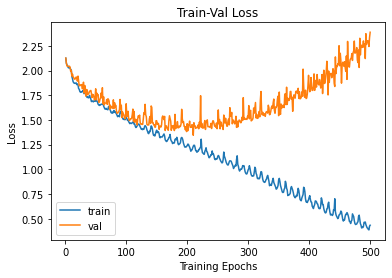

In [123]:
num_epochs=params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

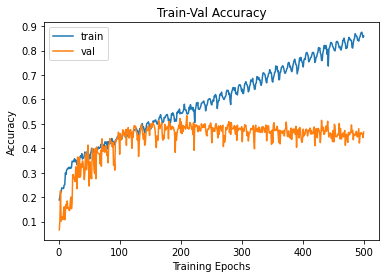

In [124]:
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()